In [1]:
import json
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt

In [2]:
root_directory_for_pbns = (
    "/scratch/zhivar/robust-prototype-learning/PBN_transformer/summaries"
)

root_directory_for_normal_models = (
    "/scratch/zhivar/robust-prototype-learning/datasets/summaries"
)

In [3]:
dataset_to_proper_name = {
    "imdb": "IMDB",
    "ag_news": "AG_News",
    "dbpedia": "DBPedia",
}

In [4]:
def get_attack_type(file_path):
    for attack_type in ["textfooler", "textbugger", "deepwordbug", "pwws", "bae"]:
        if attack_type.lower() in file_path.lower():
            return attack_type
    raise ValueError(f"Unknown attack type for file {file_path}")


def get_classifier_model(file_path):
    for classifier in [
        "electra-base-discriminator",
        "bart-base-mnli",
        "bert-medium",
        "electra",
        "bert",
        "bart",
    ]:
        if classifier.lower() in file_path.lower():
            return classifier.split("-")[0]
    return "bart"


def get_dataset(file_path):
    for dataset in ["imdb", "sst2", "ag_news", "dbpedia"]:
        if dataset.lower() in file_path.lower():
            return dataset
    raise ValueError(f"Unknown dataset for file {file_path}")


def is_cosine_dist_function(file_path):
    if "cosine" in file_path.lower():
        return True
    return False


def get_the_hyperparameters(file_path):
    dictionary_to_correct_values = {
        0: 0.0,
        9: 0.9,
        100: 10.0,
        2: 2,
        4: 4,
        8: 8,
        16: 16,
        64: 64,
    }
    pattern_to_look_for = re.compile(r".*_(\d+)\_(\d+)\_(\d+)\_(\d+).*")
    second_pattern_to_look_for = re.compile(r".*_(\d+)_(\d+)_(\d+).*")

    matched_integers = re.match(pattern_to_look_for, file_path)
    if matched_integers:
        return [dictionary_to_correct_values[int(x)] for x in matched_integers.groups()]
    else:
        matched_integers = re.match(second_pattern_to_look_for, file_path)
        if matched_integers:
            return [
                dictionary_to_correct_values[int(x)]
                for x in (*matched_integers.groups(), 16)
            ]
    raise ValueError(f"Could not find hyperparameters for file {file_path}")

In [5]:
random_file_name_1 = "summary_ag_news_textbugger_BERT_ag_news_model_09_09_09_4.json"
random_file_name_2 = "summary_ag_news_textbugger_ag_news_model_09_09_09_ELECTRA.json"
random_file_name_3 = "summary_ag_news_textfooler_BERT_ag_news_model_09_100_09_16.json"
random_file_name_4 = "summary_imdb_deepwordbug_ELECTRA_imdb_model_100_09_09_16.json"

for file_name in [
    random_file_name_1,
    random_file_name_2,
    random_file_name_3,
    random_file_name_4,
]:
    print(get_the_hyperparameters(file_name))

[0.9, 0.9, 0.9, 4]
[0.9, 0.9, 0.9, 16]
[0.9, 10.0, 0.9, 16]
[10.0, 0.9, 0.9, 16]


In [6]:
def process_file_pbn(log_file, root_directory):
    with open(os.path.join(root_directory, log_file), "r") as f:
        data = json.load(f)
        f.close()
    if "result" in data.keys():
        data_object = {
            "file_path": log_file,
            "attack_type": get_attack_type(log_file),
            "classifier_model": get_classifier_model(log_file),
            "dataset": get_dataset(log_file),
            "hyperparameters": get_the_hyperparameters(log_file),
            "is_cosine": is_cosine_dist_function(log_file),
            "comment": data["result"],
        }
    else:
        data = data["Attack Results"]
        data_object = {
            "file_path": log_file,
            "attack_type": get_attack_type(log_file),
            "classifier_model": get_classifier_model(log_file),
            "dataset": get_dataset(log_file),
            "hyperparameters": get_the_hyperparameters(log_file),
            "is_cosine": is_cosine_dist_function(log_file),
            "Number of successful attacks:": data["Number of successful attacks:"],
            "Number of failed attacks:": data["Number of failed attacks:"],
            "Number of skipped attacks:": data["Number of skipped attacks:"],
            "Original accuracy:": data["Original accuracy:"],
            "Accuracy under attack:": data["Accuracy under attack:"],
            "Attack success rate:": data["Attack success rate:"],
            "Average perturbed word %:": data["Average perturbed word %:"],
            "Average num. words per input:": data["Average num. words per input:"],
            "Avg num queries:": data["Avg num queries:"],
            "comment": "successful",
        }
    return data_object

In [7]:
all_log_files = [
    file for file in os.listdir(root_directory_for_pbns) if file.startswith("summary_")
]

all_data_objects = []

for log_file in all_log_files:
    try:
        data_object = process_file_pbn(log_file, root_directory_for_pbns)
        all_data_objects.append(data_object)
    except Exception as e:
        print(e)
        print(f"Failed to process file {log_file}")
        continue

results_df_pbn = pd.DataFrame(all_data_objects)
results_df_pbn

Expecting value: line 1 column 1 (char 0)
Failed to process file summary_dbpedia_bae_BART_dbpedia_model_09_09_09_8.json
Expecting value: line 1 column 1 (char 0)
Failed to process file summary_dbpedia_textbugger_BERT_dbpedia_model_09_09_09_16_cosine.json
Expecting value: line 1 column 1 (char 0)
Failed to process file summary_dbpedia_bae_ELECTRA_dbpedia_model_09_09_09_16_cosine.json


,file_path,attack_type,classifier_model,dataset,hyperparameters,is_cosine,Number of successful attacks:,Number of failed attacks:,Number of skipped attacks:,Original accuracy:,Accuracy under attack:,Attack success rate:,Average perturbed word %:,Average num. words per input:,Avg num queries:,comment
0,summary_imdb_textfooler_imdb_model_09_09_09.json,textfooler,bart,imdb,"[0.9, 0.9, 0.9, 16]",False,800.0,106.0,71.0,92.73,10.85,88.30,12.13,230.47,1035.63,successful
1,summary_dbpedia_textfooler_dbpedia_model_09_09...,textfooler,bart,dbpedia,"[0.9, 0.9, 0.9, 16]",False,800.0,700.0,9.0,99.40,46.39,53.33,25.99,103.83,918.13,successful
2,summary_imdb_textbugger_imdb_model_09_09_09.json,textbugger,bart,imdb,"[0.9, 0.9, 0.9, 16]",False,800.0,1020.0,128.0,93.43,52.36,43.96,28.40,227.61,662.42,successful
3,summary_ag_news_textfooler_ag_news_model_09_09...,textfooler,bart,ag_news,"[0.9, 0.9, 0.9, 16]",False,800.0,487.0,119.0,91.54,34.64,62.16,24.11,37.93,385.60,successful
4,summary_ag_news_textbugger_ag_news_model_09_09...,textbugger,bart,ag_news,"[0.9, 0.9, 0.9, 16]",False,800.0,2456.0,274.0,92.24,69.58,24.57,30.61,38.32,184.35,successful
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,summary_imdb_bae_ELECTRA_imdb_model_09_09_09_1...,bae,electra,imdb,"[0.9, 0.9, 0.9, 16]",True,800.0,1067.0,109.0,94.48,54.00,42.85,5.11,227.19,444.18,successful
478,summary_imdb_textfooler_ELECTRA_imdb_model_09_...,textfooler,electra,imdb,"[0.9, 0.9, 0.9, 16]",True,800.0,218.0,64.0,94.09,20.15,78.59,11.34,230.74,1215.67,successful
479,summary_imdb_textbugger_ELECTRA_imdb_model_09_...,textbugger,electra,imdb,"[0.9, 0.9, 0.9, 16]",True,800.0,607.0,78.0,94.75,40.88,56.86,28.90,226.91,590.47,successful
480,summary_imdb_deepwordbug_ELECTRA_imdb_model_09...,deepwordbug,electra,imdb,"[0.9, 0.9, 0.9, 16]",True,800.0,1372.0,130.0,94.35,59.60,36.83,5.76,227.93,356.62,successful


In [8]:
def is_attacked_normal_model(file_path):
    for classifier in [
        "electra-base-discriminator",
        "bart-base-mnli",
        "bert-medium",
    ]:
        if classifier.lower() in file_path.lower():
            return True
    return False

In [9]:
def process_file_non_pbn(log_file, root_directory):
    with open(os.path.join(root_directory, log_file), "r") as f:
        data = json.load(f)
        f.close()

    data = data["Attack Results"]
    data_object = {
        "file_path": log_file,
        "attack_type": get_attack_type(log_file),
        "classifier_model": get_classifier_model(log_file),
        "dataset": get_dataset(log_file),
        "hyperparameters": None,
        "Number of successful attacks:": data["Number of successful attacks:"],
        "Number of failed attacks:": data["Number of failed attacks:"],
        "Number of skipped attacks:": data["Number of skipped attacks:"],
        "Original accuracy:": data["Original accuracy:"],
        "Accuracy under attack:": data["Accuracy under attack:"],
        "Attack success rate:": data["Attack success rate:"],
        "Average perturbed word %:": data["Average perturbed word %:"],
        "Average num. words per input:": data["Average num. words per input:"],
        "Avg num queries:": data["Avg num queries:"],
        "comment": "successful",
    }
    return data_object

In [10]:
all_log_files = [
    file
    for file in os.listdir(root_directory_for_normal_models)
    if file.startswith("summary_")
]

all_data_objects = []

for log_file in all_log_files:
    if not is_attacked_normal_model(log_file):
        continue
    try:
        data_object = process_file_non_pbn(log_file, root_directory_for_normal_models)
        all_data_objects.append(data_object)
    except Exception as e:
        print(e)
        continue

results_df_non_pbns = pd.DataFrame(all_data_objects)
results_df_non_pbns.head(3)

,file_path,attack_type,classifier_model,dataset,hyperparameters,Number of successful attacks:,Number of failed attacks:,Number of skipped attacks:,Original accuracy:,Accuracy under attack:,Attack success rate:,Average perturbed word %:,Average num. words per input:,Avg num queries:,comment
0,summary_imdb_textfooler__normal_models_models_...,textfooler,bart,imdb,None,800,0,73,91.64,0.00,100.00,5.92,231.20,442.62,successful
1,summary_imdb_textbugger__normal_models_models_...,textbugger,bart,imdb,None,800,219,85,92.30,19.84,78.51,33.32,230.43,428.52,successful
2,summary_ag_news_textfooler__normal_models_mode...,textfooler,bart,ag_news,None,800,246,93,91.83,21.60,76.48,25.00,37.90,333.32,successful


In [11]:
results_df_pbn = results_df_pbn[results_df_pbn["comment"] == "successful"]
results_df_pbn["comment"] = "PBN"
results_df_non_pbns["comment"] = "non_PBN"

/tmp/ipykernel_108639/3444515158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_pbn["comment"] = "PBN"


In [12]:
results_df_merged = pd.concat([results_df_pbn, results_df_non_pbns])
results_df_merged.head(3)

,file_path,attack_type,classifier_model,dataset,hyperparameters,is_cosine,Number of successful attacks:,Number of failed attacks:,Number of skipped attacks:,Original accuracy:,Accuracy under attack:,Attack success rate:,Average perturbed word %:,Average num. words per input:,Avg num queries:,comment
0,summary_imdb_textfooler_imdb_model_09_09_09.json,textfooler,bart,imdb,"[0.9, 0.9, 0.9, 16]",False,800.0,106.0,71.0,92.73,10.85,88.30,12.13,230.47,1035.63,PBN
1,summary_dbpedia_textfooler_dbpedia_model_09_09...,textfooler,bart,dbpedia,"[0.9, 0.9, 0.9, 16]",False,800.0,700.0,9.0,99.40,46.39,53.33,25.99,103.83,918.13,PBN
2,summary_imdb_textbugger_imdb_model_09_09_09.json,textbugger,bart,imdb,"[0.9, 0.9, 0.9, 16]",False,800.0,1020.0,128.0,93.43,52.36,43.96,28.40,227.61,662.42,PBN


# Analysis on the attack success rate

In [13]:
attack_success_rate_summary_results = (
    results_df_merged.groupby(["dataset", "classifier_model", "attack_type"])
    .apply(
        lambda x: (
            x[x["comment"] == "PBN"]["Attack success rate:"].mean(),
            x[x["comment"] == "non_PBN"]["Attack success rate:"].mean(),
        )
    )
    .reset_index()
    .rename(columns={0: "Attack success rate"})
)
print(
    "The rate at which the PBN model attack success rate is lower than non PBN model attack success rate (on average)",
    attack_success_rate_summary_results[
        attack_success_rate_summary_results["Attack success rate"].apply(
            lambda x: x[0] < x[1]
        )
    ].shape[0]
    / attack_success_rate_summary_results.shape[0],
)

# same analysis but per dataset
for dataset in attack_success_rate_summary_results["dataset"].unique():
    for attack_type in attack_success_rate_summary_results[
        attack_success_rate_summary_results["dataset"] == dataset
    ]["attack_type"].unique():
        dataset_results = attack_success_rate_summary_results[
            (attack_success_rate_summary_results["dataset"] == dataset)
            & (attack_success_rate_summary_results["attack_type"] == attack_type)
        ]
        print(
            f"Dataset: {dataset} - Attack type: {attack_type} - The rate at which the PBN model attack success rate is lower than non PBN model attack success rate  (on average)",
            dataset_results[
                dataset_results["Attack success rate"].apply(lambda x: x[0] < x[1])
            ].shape[0]
            / dataset_results.shape[0],
        )

The rate at which the PBN model attack success rate is lower than non PBN model attack success rate (on average) 1.0
Dataset: ag_news - Attack type: bae - The rate at which the PBN model attack success rate is lower than non PBN model attack success rate  (on average) 1.0
Dataset: ag_news - Attack type: deepwordbug - The rate at which the PBN model attack success rate is lower than non PBN model attack success rate  (on average) 1.0
Dataset: ag_news - Attack type: pwws - The rate at which the PBN model attack success rate is lower than non PBN model attack success rate  (on average) 1.0
Dataset: ag_news - Attack type: textbugger - The rate at which the PBN model attack success rate is lower than non PBN model attack success rate  (on average) 1.0
Dataset: ag_news - Attack type: textfooler - The rate at which the PBN model attack success rate is lower than non PBN model attack success rate  (on average) 1.0
Dataset: dbpedia - Attack type: bae - The rate at which the PBN model attack suc

In [14]:
attack_success_rate_summary_results = (
    results_df_merged.groupby(["dataset", "classifier_model", "attack_type"])
    .apply(
        lambda x: (
            x[x["comment"] == "PBN"]["Attack success rate:"].min(),
            x[x["comment"] == "non_PBN"]["Attack success rate:"].min(),
        )
    )
    .reset_index()
    .rename(columns={0: "Attack success rate"})
)
print(
    "The rate at which the PBN model attack success rate is lower than non PBN model attack success rate (taking the best hyperparameters)",
    attack_success_rate_summary_results[
        attack_success_rate_summary_results["Attack success rate"].apply(
            lambda x: x[0] < x[1]
        )
    ].shape[0]
    / attack_success_rate_summary_results.shape[0],
)

# same analysis but per dataset
for dataset in attack_success_rate_summary_results["dataset"].unique():
    dataset_results = attack_success_rate_summary_results[
        attack_success_rate_summary_results["dataset"] == dataset
    ]
    print(
        f"Dataset: {dataset} - The rate at which the PBN model attack success rate is lower than non PBN model attack success rate (taking the best hyperparameters)",
        dataset_results[
            dataset_results["Attack success rate"].apply(lambda x: x[0] < x[1])
        ].shape[0]
        / dataset_results.shape[0],
    )
print("-----------------------------------")
# same analysis but per dataset and attack type
for dataset in attack_success_rate_summary_results["dataset"].unique():
    for attack_type in attack_success_rate_summary_results[
        attack_success_rate_summary_results["dataset"] == dataset
    ]["attack_type"].unique():
        dataset_results = attack_success_rate_summary_results[
            (attack_success_rate_summary_results["dataset"] == dataset)
            & (attack_success_rate_summary_results["attack_type"] == attack_type)
        ]
        print(
            f"Dataset: {dataset} - Attack type: {attack_type} - The rate at which the PBN model attack success rate is lower than non PBN model attack success rate (taking the best hyperparameters)",
            dataset_results[
                dataset_results["Attack success rate"].apply(lambda x: x[0] < x[1])
            ].shape[0]
            / dataset_results.shape[0],
        )

The rate at which the PBN model attack success rate is lower than non PBN model attack success rate (taking the best hyperparameters) 1.0
Dataset: ag_news - The rate at which the PBN model attack success rate is lower than non PBN model attack success rate (taking the best hyperparameters) 1.0
Dataset: dbpedia - The rate at which the PBN model attack success rate is lower than non PBN model attack success rate (taking the best hyperparameters) 1.0
Dataset: imdb - The rate at which the PBN model attack success rate is lower than non PBN model attack success rate (taking the best hyperparameters) 1.0
-----------------------------------
Dataset: ag_news - Attack type: bae - The rate at which the PBN model attack success rate is lower than non PBN model attack success rate (taking the best hyperparameters) 1.0
Dataset: ag_news - Attack type: deepwordbug - The rate at which the PBN model attack success rate is lower than non PBN model attack success rate (taking the best hyperparameters) 1.

In [15]:
attack_success_rate_summary_results.head(3)

,dataset,classifier_model,attack_type,Attack success rate
0,ag_news,bart,bae,"(11.09, 14.82)"
1,ag_news,bart,deepwordbug,"(32.3, 53.16)"
2,ag_news,bart,pwws,"(41.26, 53.62)"


In [16]:
a = pd.DataFrame(
    results_df_merged[results_df_merged["comment"] == "PBN"]
    .groupby(["dataset", "attack_type", "classifier_model"])["Attack success rate:"]
    .min()
).reset_index()
a["classifier_model"] = a["classifier_model"] + " + PBN"
b = pd.DataFrame(
    results_df_merged[results_df_merged["comment"] == "non_PBN"]
    .groupby(["dataset", "attack_type", "classifier_model"])["Attack success rate:"]
    .mean()
).reset_index()

print(
    pd.pivot_table(
        pd.concat([a, b]),
        index=["classifier_model"],
        columns=["dataset", "attack_type"],
        values="Attack success rate:",
        aggfunc=lambda x: np.round(x, 2),
    ).to_latex(
        multicolumn=True,
        multirow=True,
        caption="Attack success rate for PBN and non-PBN models",
        # change the precision to 2
        float_format="%.1f",
    )
)

\begin{table}
\caption{Attack success rate for PBN and non-PBN models}
\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
dataset & \multicolumn{5}{r}{ag_news} & \multicolumn{5}{r}{dbpedia} & \multicolumn{5}{r}{imdb} \\
attack_type & bae & deepwordbug & pwws & textbugger & textfooler & bae & deepwordbug & pwws & textbugger & textfooler & bae & deepwordbug & pwws & textbugger & textfooler \\
classifier_model &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
bart & 14.8 & 53.2 & 53.6 & 31.8 & 76.5 & 18.9 & 28.3 & 43.1 & 21.1 & 71.9 & 74.1 & 74.7 & 99.3 & 78.5 & 100.0 \\
bart + PBN & 11.1 & 32.3 & 41.3 & 23.1 & 62.2 & 15.2 & 14.7 & 28.7 & 12.6 & 45.5 & 36.1 & 41.0 & 75.9 & 41.3 & 73.1 \\
bert & 17.0 & 78.0 & 69.8 & 45.7 & 88.8 & 13.9 & 24.8 & 31.6 & 22.0 & 61.3 & 82.5 & 79.7 & 99.9 & 83.9 & 99.9 \\
bert + PBN & 7.7 & 42.6 & 47.0 & 30.4 & 70.5 & 9.8 & 17.3 & 21.6 & 13.0 & 41.0 & 42.8 & 41.0 & 79.7 & 57.7 & 79.8 \\
electra & 24.8 & 89.5 & 69.1 & 87.8 & 87.9 & 14.5 & 42.8 & 45.6 & 42.3 & 75.3

In [17]:
a = pd.DataFrame(
    results_df_merged[results_df_merged["comment"] == "PBN"]
    .groupby(["dataset", "attack_type", "classifier_model"])[
        "Average perturbed word %:"
    ]
    .mean()
).reset_index()
a["classifier_model"] = a["classifier_model"] + " + PBN"
b = pd.DataFrame(
    results_df_merged[results_df_merged["comment"] == "non_PBN"]
    .groupby(["dataset", "attack_type", "classifier_model"])[
        "Average perturbed word %:"
    ]
    .mean()
).reset_index()

print(
    pd.pivot_table(
        pd.concat([a, b]),
        index=["classifier_model"],
        columns=["dataset", "attack_type"],
        values="Average perturbed word %:",
        aggfunc=lambda x: np.round(x, 2),
    ).to_latex(
        multicolumn=True,
        multirow=True,
        caption="Average perturbed word % for PBN and non-PBN models",
        # change the precision to 2
        float_format="%.1f",
    )
)

\begin{table}
\caption{Average perturbed word % for PBN and non-PBN models}
\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
dataset & \multicolumn{5}{r}{ag_news} & \multicolumn{5}{r}{dbpedia} & \multicolumn{5}{r}{imdb} \\
attack_type & bae & deepwordbug & pwws & textbugger & textfooler & bae & deepwordbug & pwws & textbugger & textfooler & bae & deepwordbug & pwws & textbugger & textfooler \\
classifier_model &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
bart & 8.7 & 26.9 & 20.8 & 35.7 & 25.0 & 9.1 & 27.3 & 16.9 & 50.1 & 26.2 & 4.1 & 6.4 & 4.2 & 33.3 & 5.9 \\
bart + PBN & 8.3 & 19.3 & 20.5 & 32.6 & 25.2 & 9.7 & 17.1 & 15.9 & 40.4 & 24.7 & 4.4 & 6.1 & 6.5 & 29.5 & 10.1 \\
bert & 7.4 & 26.8 & 21.6 & 37.4 & 24.1 & 9.7 & 27.9 & 19.4 & 53.8 & 28.8 & 4.0 & 5.7 & 4.4 & 30.1 & 5.0 \\
bert + PBN & 7.2 & 24.1 & 21.9 & 35.0 & 25.9 & 9.5 & 24.1 & 19.3 & 43.1 & 27.6 & 4.1 & 5.5 & 5.0 & 27.3 & 7.1 \\
electra & 8.2 & 23.7 & 17.5 & 32.7 & 20.8 & 10.9 & 24.6 & 17.7 & 58.0 & 22.9 & 5.4 & 8.1 & 8.8

In [18]:
a = pd.DataFrame(
    results_df_merged[results_df_merged["comment"] == "PBN"]
    .groupby(["dataset", "attack_type", "classifier_model"])["Original accuracy:"]
    .mean()
).reset_index()
a["classifier_model"] = a["classifier_model"] + " + PBN"
b = pd.DataFrame(
    results_df_merged[results_df_merged["comment"] == "non_PBN"]
    .groupby(["dataset", "attack_type", "classifier_model"])["Original accuracy:"]
    .mean()
).reset_index()

print(
    pd.pivot_table(
        pd.concat([a, b]),
        index=["classifier_model"],
        columns=["dataset", "attack_type"],
        values="Original accuracy:",
        aggfunc=lambda x: np.round(x, 2),
    ).to_latex(
        multicolumn=True,
        multirow=True,
        caption="Original accuracy for PBN and non-PBN models",
        # change the precision to 2
        float_format="%.1f",
    )
)

\begin{table}
\caption{Original accuracy for PBN and non-PBN models}
\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
dataset & \multicolumn{5}{r}{ag_news} & \multicolumn{5}{r}{dbpedia} & \multicolumn{5}{r}{imdb} \\
attack_type & bae & deepwordbug & pwws & textbugger & textfooler & bae & deepwordbug & pwws & textbugger & textfooler & bae & deepwordbug & pwws & textbugger & textfooler \\
classifier_model &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
bart & 92.3 & 92.0 & 92.1 & 92.4 & 91.8 & 98.7 & 98.7 & 98.7 & 98.7 & 98.8 & 92.6 & 92.7 & 91.7 & 92.3 & 91.6 \\
bart + PBN & 91.0 & 91.2 & 91.1 & 91.4 & 91.0 & 98.9 & 98.9 & 99.0 & 99.1 & 99.2 & 92.9 & 92.8 & 92.2 & 92.9 & 92.3 \\
bert & 90.9 & 90.5 & 90.3 & 91.0 & 90.8 & 99.1 & 99.3 & 99.3 & 99.3 & 99.1 & 89.7 & 90.0 & 89.7 & 89.8 & 89.7 \\
bert + PBN & 83.7 & 83.2 & 83.3 & 84.1 & 83.8 & 98.5 & 98.7 & 98.7 & 98.6 & 98.6 & 91.5 & 91.5 & 91.1 & 91.1 & 90.7 \\
electra & 86.2 & 86.2 & 85.2 & 86.1 & 86.1 & 98.8 & 98.9 & 98.9 & 99.0 & 98.8 

In [19]:
results_df_pbn["p1_lamb"] = results_df_pbn["hyperparameters"].apply(lambda x: x[0])
results_df_pbn["p2_lamb"] = results_df_pbn["hyperparameters"].apply(lambda x: x[1])
results_df_pbn["p3_lamb"] = results_df_pbn["hyperparameters"].apply(lambda x: x[2])
results_df_pbn["num_proto"] = results_df_pbn["hyperparameters"].apply(lambda x: x[3])

/tmp/ipykernel_108639/2201319661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_pbn["p1_lamb"] = results_df_pbn["hyperparameters"].apply(lambda x: x[0])
/tmp/ipykernel_108639/2201319661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_pbn["p2_lamb"] = results_df_pbn["hyperparameters"].apply(lambda x: x[1])
/tmp/ipykernel_108639/2201319661.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

82.42933333333333
59.22533333333334
37.150666666666666


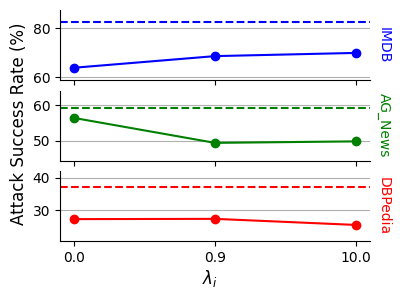

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(4, 3), sharex=True)
dataset_to_colors = {
    "imdb": "blue",
    "ag_news": "green",
    "dbpedia": "red",
}
for ax, dataset in zip(axs, ["imdb", "ag_news", "dbpedia"]):
    sub_df = results_df_pbn[results_df_pbn["dataset"] == dataset]
    results = sub_df.groupby("p1_lamb")["Attack success rate:"].mean()
    non_pbn_baseline = results_df_non_pbns[(results_df_non_pbns["dataset"] == dataset)][
        "Attack success rate:"
    ].mean()
    print(non_pbn_baseline)
    x = results.index
    y = results.values
    x_to_y = dict(zip(x, y))
    correct_indices = [0.0, 0.9, 10.0]

    ax.plot(
        range(len(correct_indices)),
        [x_to_y.get(i, non_pbn_baseline + 5) for i in correct_indices],
        label=dataset,
        color=dataset_to_colors[dataset],
        marker="o",
    )

    ax.axhline(
        y=non_pbn_baseline,
        color=dataset_to_colors[dataset],
        linestyle="--",
        # label="non-PBN",
    )
    ax.set_ylim(min(min(y), non_pbn_baseline) - 5, max(max(y), non_pbn_baseline) + 5)
    ax.grid(axis="y")
    ax.set_xticks(range(len(correct_indices)))
    ax.set_xticklabels(correct_indices)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(
        dataset_to_proper_name[dataset],
        rotation=-90,
        labelpad=15,
        color=dataset_to_colors[dataset],
    )


for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


# handles = []
# labels = []
# for ax in axs:
#     for h, l in zip(*ax.get_legend_handles_labels()):
#         handles.append(h)
#         labels.append(l)
# handles.append(plt.Line2D([0], [0], color="black", linestyle="--"))
# labels.append("non-PBN")
# fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.45, 1.0))


fig.supxlabel(r"$\lambda_{i}$", y=-0.05, ha="center")
fig.supylabel("Attack Success Rate (%)", x=0.0, ha="left")


fig.subplots_adjust(hspace=0.15)
plt.savefig("figures/attack_success_rate_pi_lamb.png", dpi=300, bbox_inches="tight")
plt.show()

82.42933333333333
59.22533333333334
37.150666666666666


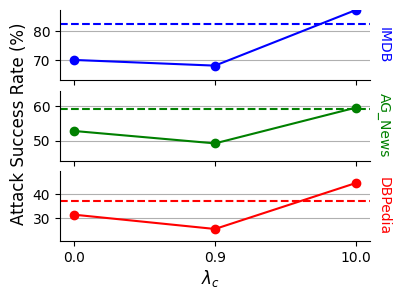

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(4, 3), sharex=True)
dataset_to_colors = {
    "imdb": "blue",
    "ag_news": "green",
    "dbpedia": "red",
}
for ax, dataset in zip(axs, ["imdb", "ag_news", "dbpedia"]):
    sub_df = results_df_pbn[results_df_pbn["dataset"] == dataset]
    results = sub_df.groupby("p2_lamb")["Attack success rate:"].mean()
    non_pbn_baseline = results_df_non_pbns[(results_df_non_pbns["dataset"] == dataset)][
        "Attack success rate:"
    ].mean()
    print(non_pbn_baseline)
    x = results.index
    y = results.values
    x_to_y = dict(zip(x, y))
    correct_indices = [0.0, 0.9, 10.0]

    ax.plot(
        range(len(correct_indices)),
        [x_to_y.get(i, non_pbn_baseline + 5) for i in correct_indices],
        label=dataset,
        color=dataset_to_colors[dataset],
        marker="o",
    )
    ax.axhline(
        y=non_pbn_baseline,
        color=dataset_to_colors[dataset],
        linestyle="--",
        # label="non-PBN",
    )
    ax.set_ylim(min(min(y), non_pbn_baseline) - 5, max(max(y), non_pbn_baseline) + 5)
    ax.grid(axis="y")
    ax.set_xticks(range(len(correct_indices)))
    ax.set_xticklabels(correct_indices)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(
        dataset_to_proper_name[dataset],
        rotation=-90,
        labelpad=15,
        color=dataset_to_colors[dataset],
    )


for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


# handles = []
# labels = []
# for ax in axs:
#     for h, l in zip(*ax.get_legend_handles_labels()):
#         handles.append(h)
#         labels.append(l)
# handles.append(plt.Line2D([0], [0], color="black", linestyle="--"))
# labels.append("non-PBN")
# fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.45, 1.0))


fig.supxlabel(r"$\lambda_{c}$", y=-0.05, ha="center")
fig.supylabel("Attack Success Rate (%)", x=0.0, ha="left")

fig.subplots_adjust(hspace=0.15)
plt.savefig("figures/attack_success_rate_pc_lamb.png", dpi=300, bbox_inches="tight")
plt.show()

82.42933333333333
59.22533333333334
37.150666666666666


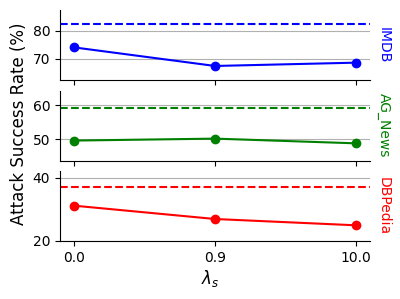

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(4, 3), sharex=True)
dataset_to_colors = {
    "imdb": "blue",
    "ag_news": "green",
    "dbpedia": "red",
}
for ax, dataset in zip(axs, ["imdb", "ag_news", "dbpedia"]):
    sub_df = results_df_pbn[results_df_pbn["dataset"] == dataset]
    results = sub_df.groupby("p3_lamb")["Attack success rate:"].mean()
    non_pbn_baseline = results_df_non_pbns[(results_df_non_pbns["dataset"] == dataset)][
        "Attack success rate:"
    ].mean()
    print(non_pbn_baseline)
    x = results.index
    y = results.values
    x_to_y = dict(zip(x, y))
    correct_indices = [0.0, 0.9, 10.0]

    ax.plot(
        range(len(correct_indices)),
        [x_to_y.get(i, non_pbn_baseline + 5) for i in correct_indices],
        label=dataset,
        color=dataset_to_colors[dataset],
        marker="o",
    )
    ax.axhline(
        y=non_pbn_baseline,
        color=dataset_to_colors[dataset],
        linestyle="--",
        # label="non-PBN",
    )
    ax.set_ylim(min(min(y), non_pbn_baseline) - 5, max(max(y), non_pbn_baseline) + 5)
    ax.grid(axis="y")
    ax.set_xticks(range(len(correct_indices)))
    ax.set_xticklabels(correct_indices)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(
        dataset_to_proper_name[dataset],
        rotation=-90,
        labelpad=15,
        color=dataset_to_colors[dataset],
    )


for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


# handles = []
# labels = []
# for ax in axs:
#     for h, l in zip(*ax.get_legend_handles_labels()):
#         handles.append(h)
#         labels.append(l)

# handles.append(plt.Line2D([0], [0], color="black", linestyle="--"))
# labels.append("non-PBN")
# fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.45, 1.0))


fig.supxlabel(r"$\lambda_{s}$", y=-0.05, ha="center")
fig.supylabel("Attack Success Rate (%)", x=0.0, ha="left")


fig.subplots_adjust(hspace=0.15)
plt.savefig("figures/attack_success_rate_ps_lamb.png", dpi=300, bbox_inches="tight")
plt.show()

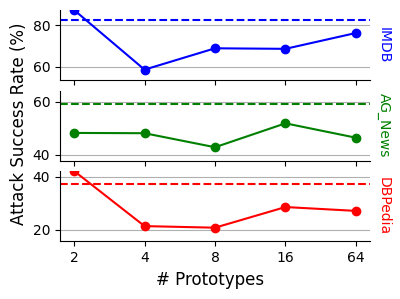

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(4, 3), sharex=True)
dataset_to_colors = {
    "imdb": "blue",
    "ag_news": "green",
    "dbpedia": "red",
}
for ax, dataset in zip(axs, ["imdb", "ag_news", "dbpedia"]):
    sub_df = results_df_pbn[results_df_pbn["dataset"] == dataset]
    results = sub_df.groupby("num_proto")["Attack success rate:"].mean()
    non_pbn_baseline = results_df_non_pbns[(results_df_non_pbns["dataset"] == dataset)][
        "Attack success rate:"
    ].mean()

    x = results.index
    y = results.values
    x_to_y = dict(zip(x, y))
    correct_indices = [2, 4, 8, 16, 64]

    ax.plot(
        range(len(correct_indices)),
        [x_to_y.get(i, non_pbn_baseline + 5) for i in correct_indices],
        label=dataset,
        color=dataset_to_colors[dataset],
        marker="o",
    )
    ax.axhline(
        y=non_pbn_baseline,
        color=dataset_to_colors[dataset],
        linestyle="--",
        # label="non-PBN",
    )
    ax.set_ylim(min(min(y), non_pbn_baseline) - 5, max(max(y), non_pbn_baseline) + 5)
    ax.grid(axis="y")
    ax.set_xticks(range(len(correct_indices)))
    ax.set_xticklabels(correct_indices)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(
        dataset_to_proper_name[dataset],
        rotation=-90,
        labelpad=15,
        color=dataset_to_colors[dataset],
    )

for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# handles = []
# labels = []
# for ax in axs:
#     for h, l in zip(*ax.get_legend_handles_labels()):
#         handles.append(h)
#         labels.append(l)
# # add another label for non-PBN, black and dashed
# handles.append(plt.Line2D([0], [0], color="black", linestyle="--"))
# labels.append("non-PBN")
# fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.45, 1.0))


fig.supxlabel("# Prototypes", y=-0.05, ha="center")
fig.supylabel("Attack Success Rate (%)", x=0.0, ha="left")


fig.subplots_adjust(hspace=0.15)
plt.savefig("figures/attack_success_rate_num_proto.png", dpi=300, bbox_inches="tight")
plt.show()

149
36
170
31
106
25


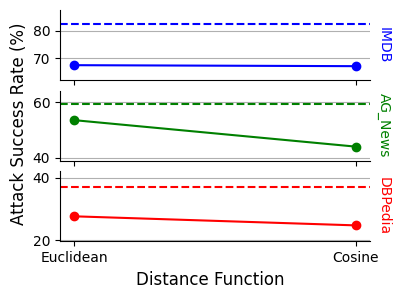

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(4, 3), sharex=True)
dataset_to_colors = {
    "imdb": "blue",
    "ag_news": "green",
    "dbpedia": "red",
}
for ax, dataset in zip(axs, ["imdb", "ag_news", "dbpedia"]):
    sub_df = results_df_pbn[results_df_pbn["dataset"] == dataset]
    print(len(sub_df))
    sub_df = sub_df[sub_df["hyperparameters"].apply(lambda x: x == [0.9, 0.9, 0.9, 16])]
    print(len(sub_df))
    results = sub_df.groupby("is_cosine")["Attack success rate:"].mean()
    non_pbn_baseline = results_df_non_pbns[(results_df_non_pbns["dataset"] == dataset)][
        "Attack success rate:"
    ].mean()

    x = results.index
    y = results.values
    x_to_y = dict(zip(x, y))
    correct_indices = [False, True]

    ax.plot(
        range(len(correct_indices)),
        [x_to_y.get(i, non_pbn_baseline + 5) for i in correct_indices],
        label=dataset,
        color=dataset_to_colors[dataset],
        marker="o",
    )
    ax.axhline(
        y=non_pbn_baseline,
        color=dataset_to_colors[dataset],
        linestyle="--",
        # label="non-PBN",
    )
    ax.set_ylim(min(min(y), non_pbn_baseline) - 5, max(max(y), non_pbn_baseline) + 5)
    ax.grid(axis="y")
    ax.set_xticks(range(len(correct_indices)))
    ax.set_xticklabels(["Euclidean", "Cosine"])
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(
        dataset_to_proper_name[dataset],
        rotation=-90,
        labelpad=15,
        color=dataset_to_colors[dataset],
    )

for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# handles = []
# labels = []
# for ax in axs:
#     for h, l in zip(*ax.get_legend_handles_labels()):
#         handles.append(h)
#         labels.append(l)
# handles.append(plt.Line2D([0], [0], color="black", linestyle="--"))
# labels.append("non-PBN")
# fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.45, 1.0))


fig.supxlabel("Distance Function", y=-0.05, ha="center")
fig.supylabel("Attack Success Rate (%)", x=0.0, ha="left")

fig.subplots_adjust(hspace=0.15)
plt.savefig(
    "figures/attack_success_rate_distance_function.png", dpi=300, bbox_inches="tight"
)
plt.show()

# Analysis on the Average ratio of the perturbed words 

In [25]:
average_perturbed_word_summary_results = (
    results_df_merged.groupby(["dataset", "classifier_model", "attack_type"])
    .apply(
        lambda x: (
            x[x["comment"] == "PBN"]["Average perturbed word %:"].mean(),
            x[x["comment"] == "non_PBN"]["Average perturbed word %:"].mean(),
        )
    )
    .reset_index()
    .rename(columns={0: "Average perturbed word %"})
)
print(
    "The rate at which the % average number of perturbations is higher in PBN model than non PBN model (on average)",
    np.round(
        average_perturbed_word_summary_results[
            average_perturbed_word_summary_results["Average perturbed word %"].apply(
                lambda x: x[0] > x[1]
            )
        ].shape[0]
        / average_perturbed_word_summary_results.shape[0],
        2,
    ),
)

# same analysis but per dataset
for dataset in average_perturbed_word_summary_results["dataset"].unique():
    dataset_results = average_perturbed_word_summary_results[
        average_perturbed_word_summary_results["dataset"] == dataset
    ]
    print(
        f"{dataset} - The rate at which the % average number of perturbations is higher in PBN model than non PBN model (on average)",
        np.round(
            dataset_results[
                dataset_results["Average perturbed word %"].apply(lambda x: x[0] > x[1])
            ].shape[0]
            / dataset_results.shape[0],
            2,
        ),
    )

The rate at which the % average number of perturbations is higher in PBN model than non PBN model (on average) 0.31
ag_news - The rate at which the % average number of perturbations is higher in PBN model than non PBN model (on average) 0.2
dbpedia - The rate at which the % average number of perturbations is higher in PBN model than non PBN model (on average) 0.13
imdb - The rate at which the % average number of perturbations is higher in PBN model than non PBN model (on average) 0.6


In [26]:
average_perturbed_word_summary_results = (
    results_df_merged.groupby(["dataset", "classifier_model", "attack_type"])
    .apply(
        lambda x: (
            x[x["comment"] == "PBN"]["Average perturbed word %:"].max(),
            x[x["comment"] == "non_PBN"]["Average perturbed word %:"].max(),
        )
    )
    .reset_index()
    .rename(columns={0: "Average perturbed word %"})
)
print(
    "The rate at which the % average number of perturbations is higher in PBN model than non PBN model (best HP)",
    np.round(
        average_perturbed_word_summary_results[
            average_perturbed_word_summary_results["Average perturbed word %"].apply(
                lambda x: x[0] > x[1]
            )
        ].shape[0]
        / average_perturbed_word_summary_results.shape[0],
        2,
    ),
)

# same analysis but per dataset
for dataset in average_perturbed_word_summary_results["dataset"].unique():
    dataset_results = average_perturbed_word_summary_results[
        average_perturbed_word_summary_results["dataset"] == dataset
    ]
    print(
        f"{dataset} - The rate at which the % average number of perturbations is higher in PBN model than non PBN model (best HP)",
        np.round(
            dataset_results[
                dataset_results["Average perturbed word %"].apply(lambda x: x[0] > x[1])
            ].shape[0]
            / dataset_results.shape[0],
            2,
        ),
    )

The rate at which the % average number of perturbations is higher in PBN model than non PBN model (best HP) 0.71
ag_news - The rate at which the % average number of perturbations is higher in PBN model than non PBN model (best HP) 0.67
dbpedia - The rate at which the % average number of perturbations is higher in PBN model than non PBN model (best HP) 0.53
imdb - The rate at which the % average number of perturbations is higher in PBN model than non PBN model (best HP) 0.93


12.082666666666666
22.49
26.891333333333332


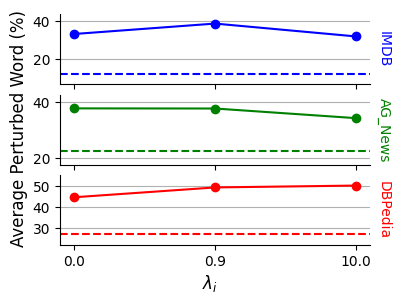

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(4, 3), sharex=True)
dataset_to_colors = {
    "imdb": "blue",
    "ag_news": "green",
    "dbpedia": "red",
}
for ax, dataset in zip(axs, ["imdb", "ag_news", "dbpedia"]):
    sub_df = results_df_pbn[results_df_pbn["dataset"] == dataset]
    results = sub_df.groupby("p1_lamb")["Average perturbed word %:"].max()
    non_pbn_baseline = results_df_non_pbns[(results_df_non_pbns["dataset"] == dataset)][
        "Average perturbed word %:"
    ].mean()
    print(non_pbn_baseline)
    x = results.index
    y = results.values
    x_to_y = dict(zip(x, y))
    correct_indices = [0.0, 0.9, 10.0]

    ax.plot(
        range(len(correct_indices)),
        [x_to_y.get(i, non_pbn_baseline + 5) for i in correct_indices],
        label=dataset,
        color=dataset_to_colors[dataset],
        marker="o",
    )

    ax.axhline(
        y=non_pbn_baseline,
        color=dataset_to_colors[dataset],
        linestyle="--",
        # label="non-PBN",
    )
    ax.set_ylim(min(min(y), non_pbn_baseline) - 5, max(max(y), non_pbn_baseline) + 5)
    ax.grid(axis="y")
    ax.set_xticks(range(len(correct_indices)))
    ax.set_xticklabels(correct_indices)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(
        dataset_to_proper_name[dataset],
        rotation=-90,
        labelpad=15,
        color=dataset_to_colors[dataset],
    )


for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


# handles = []
# labels = []
# for ax in axs:
#     for h, l in zip(*ax.get_legend_handles_labels()):
#         handles.append(h)
#         labels.append(l)
# handles.append(plt.Line2D([0], [0], color="black", linestyle="--"))
# labels.append("non-PBN")
# fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.45, 1.0))


fig.supxlabel(r"$\lambda_{i}$", y=-0.05, ha="center")
fig.supylabel("Average Perturbed Word (%)", x=0.0, ha="left")


fig.subplots_adjust(hspace=0.15)
plt.savefig("figures/average_perturbed_word_pi_lamb.png", dpi=300, bbox_inches="tight")
plt.show()

12.082666666666666
22.49
26.891333333333332


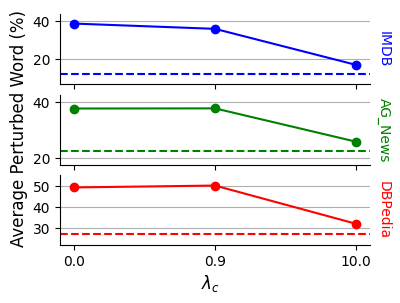

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(4, 3), sharex=True)
dataset_to_colors = {
    "imdb": "blue",
    "ag_news": "green",
    "dbpedia": "red",
}
for ax, dataset in zip(axs, ["imdb", "ag_news", "dbpedia"]):
    sub_df = results_df_pbn[results_df_pbn["dataset"] == dataset]
    results = sub_df.groupby("p2_lamb")["Average perturbed word %:"].max()
    non_pbn_baseline = results_df_non_pbns[(results_df_non_pbns["dataset"] == dataset)][
        "Average perturbed word %:"
    ].mean()
    print(non_pbn_baseline)
    x = results.index
    y = results.values
    x_to_y = dict(zip(x, y))
    correct_indices = [0.0, 0.9, 10.0]

    ax.plot(
        range(len(correct_indices)),
        [x_to_y.get(i, non_pbn_baseline + 5) for i in correct_indices],
        label=dataset,
        color=dataset_to_colors[dataset],
        marker="o",
    )

    ax.axhline(
        y=non_pbn_baseline,
        color=dataset_to_colors[dataset],
        linestyle="--",
        # label="non-PBN",
    )
    ax.set_ylim(min(min(y), non_pbn_baseline) - 5, max(max(y), non_pbn_baseline) + 5)
    ax.grid(axis="y")
    ax.set_xticks(range(len(correct_indices)))
    ax.set_xticklabels(correct_indices)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(
        dataset_to_proper_name[dataset],
        rotation=-90,
        labelpad=15,
        color=dataset_to_colors[dataset],
    )


for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


# handles = []
# labels = []
# for ax in axs:
#     for h, l in zip(*ax.get_legend_handles_labels()):
#         handles.append(h)
#         labels.append(l)
# handles.append(plt.Line2D([0], [0], color="black", linestyle="--"))
# labels.append("non-PBN")
# fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.45, 1.0))


fig.supxlabel(r"$\lambda_{c}$", y=-0.05, ha="center")
fig.supylabel("Average Perturbed Word (%)", x=0.0, ha="left")


fig.subplots_adjust(hspace=0.15)
plt.savefig("figures/average_perturbed_word_pc_lamb.png", dpi=300, bbox_inches="tight")
plt.show()

12.082666666666666
22.49
26.891333333333332


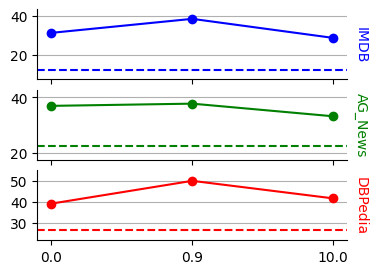

In [29]:
fig, axs = plt.subplots(3, 1, figsize=(4, 3), sharex=True)
dataset_to_colors = {
    "imdb": "blue",
    "ag_news": "green",
    "dbpedia": "red",
}
for ax, dataset in zip(axs, ["imdb", "ag_news", "dbpedia"]):
    sub_df = results_df_pbn[results_df_pbn["dataset"] == dataset]
    results = sub_df.groupby("p3_lamb")["Average perturbed word %:"].max()
    non_pbn_baseline = results_df_non_pbns[(results_df_non_pbns["dataset"] == dataset)][
        "Average perturbed word %:"
    ].mean()
    print(non_pbn_baseline)
    x = results.index
    y = results.values
    x_to_y = dict(zip(x, y))
    correct_indices = [0.0, 0.9, 10.0]

    ax.plot(
        range(len(correct_indices)),
        [x_to_y.get(i, non_pbn_baseline + 5) for i in correct_indices],
        label=dataset,
        color=dataset_to_colors[dataset],
        marker="o",
    )

    ax.axhline(
        y=non_pbn_baseline,
        color=dataset_to_colors[dataset],
        linestyle="--",
        # label="non-PBN",
    )
    ax.set_ylim(min(min(y), non_pbn_baseline) - 5, max(max(y), non_pbn_baseline) + 5)
    ax.grid(axis="y")
    ax.set_xticks(range(len(correct_indices)))
    ax.set_xticklabels(correct_indices)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(
        dataset_to_proper_name[dataset],
        rotation=-90,
        labelpad=15,
        color=dataset_to_colors[dataset],
    )


for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


# handles = []
# labels = []
# for ax in axs:
#     for h, l in zip(*ax.get_legend_handles_labels()):
#         handles.append(h)
#         labels.append(l)
# handles.append(plt.Line2D([0], [0], color="black", linestyle="--"))
# labels.append("non-PBN")
# fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.45, 1.0))


# fig.supxlabel(r"$\lambda_{s}$", y=-0.05, ha="center")
# fig.supylabel("Average Perturbed Word (%)", x=0.0, ha="left")


fig.subplots_adjust(hspace=0.15)
plt.savefig("figures/average_perturbed_word_ps_lamb.png", dpi=300, bbox_inches="tight")
plt.show()

12.082666666666666
22.49
26.891333333333332


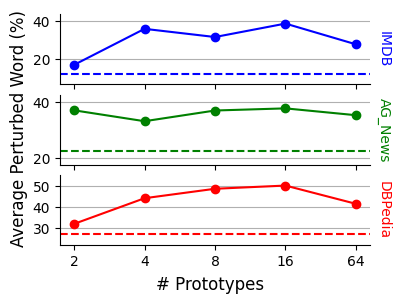

In [30]:
fig, axs = plt.subplots(3, 1, figsize=(4, 3), sharex=True)
dataset_to_colors = {
    "imdb": "blue",
    "ag_news": "green",
    "dbpedia": "red",
}
for ax, dataset in zip(axs, ["imdb", "ag_news", "dbpedia"]):
    sub_df = results_df_pbn[results_df_pbn["dataset"] == dataset]
    results = sub_df.groupby("num_proto")["Average perturbed word %:"].max()
    non_pbn_baseline = results_df_non_pbns[(results_df_non_pbns["dataset"] == dataset)][
        "Average perturbed word %:"
    ].mean()
    print(non_pbn_baseline)
    x = results.index
    y = results.values
    x_to_y = dict(zip(x, y))
    correct_indices = [2, 4, 8, 16, 64]

    ax.plot(
        range(len(correct_indices)),
        [x_to_y.get(i, non_pbn_baseline + 5) for i in correct_indices],
        label=dataset,
        color=dataset_to_colors[dataset],
        marker="o",
    )

    ax.axhline(
        y=non_pbn_baseline,
        color=dataset_to_colors[dataset],
        linestyle="--",
        # label="non-PBN",
    )
    ax.set_ylim(min(min(y), non_pbn_baseline) - 5, max(max(y), non_pbn_baseline) + 5)
    ax.grid(axis="y")
    ax.set_xticks(range(len(correct_indices)))
    ax.set_xticklabels(correct_indices)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(
        dataset_to_proper_name[dataset],
        rotation=-90,
        labelpad=15,
        color=dataset_to_colors[dataset],
    )


for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


# handles = []
# labels = []
# for ax in axs:
#     for h, l in zip(*ax.get_legend_handles_labels()):
#         handles.append(h)
#         labels.append(l)
# handles.append(plt.Line2D([0], [0], color="black", linestyle="--"))
# labels.append("non-PBN")
# fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.45, 1.0))


fig.supxlabel("# Prototypes", y=-0.05, ha="center")
fig.supylabel("Average Perturbed Word (%)", x=0.0, ha="left")


fig.subplots_adjust(hspace=0.15)
plt.savefig(
    "figures/average_perturbed_word_num_proto.png", dpi=300, bbox_inches="tight"
)
plt.show()

149
36
170
31
106
25


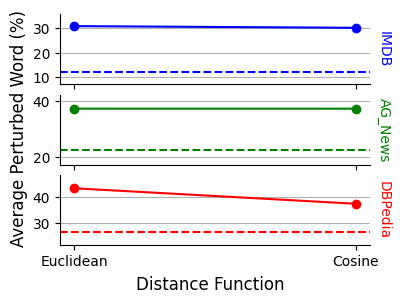

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(4, 3), sharex=True)
dataset_to_colors = {
    "imdb": "blue",
    "ag_news": "green",
    "dbpedia": "red",
}
for ax, dataset in zip(axs, ["imdb", "ag_news", "dbpedia"]):
    sub_df = results_df_pbn[results_df_pbn["dataset"] == dataset]
    print(len(sub_df))
    sub_df = sub_df[sub_df["hyperparameters"].apply(lambda x: x == [0.9, 0.9, 0.9, 16])]
    print(len(sub_df))
    results = sub_df.groupby("is_cosine")["Average perturbed word %:"].max()
    non_pbn_baseline = results_df_non_pbns[(results_df_non_pbns["dataset"] == dataset)][
        "Average perturbed word %:"
    ].mean()

    x = results.index
    y = results.values
    x_to_y = dict(zip(x, y))
    correct_indices = [False, True]

    ax.plot(
        range(len(correct_indices)),
        [x_to_y.get(i, non_pbn_baseline + 5) for i in correct_indices],
        label=dataset,
        color=dataset_to_colors[dataset],
        marker="o",
    )
    ax.axhline(
        y=non_pbn_baseline,
        color=dataset_to_colors[dataset],
        linestyle="--",
        # label="non-PBN",
    )
    ax.set_ylim(min(min(y), non_pbn_baseline) - 5, max(max(y), non_pbn_baseline) + 5)
    ax.grid(axis="y")
    ax.set_xticks(range(len(correct_indices)))
    ax.set_xticklabels(["Euclidean", "Cosine"])
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(
        dataset_to_proper_name[dataset],
        rotation=-90,
        labelpad=15,
        color=dataset_to_colors[dataset],
    )

for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# handles = []
# labels = []
# for ax in axs:
#     for h, l in zip(*ax.get_legend_handles_labels()):
#         handles.append(h)
#         labels.append(l)
# handles.append(plt.Line2D([0], [0], color="black", linestyle="--"))
# labels.append("non-PBN")
# fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.45, 1.0))


fig.supxlabel("Distance Function", y=-0.05, ha="center")
fig.supylabel("Average Perturbed Word (%)", x=0.0, ha="left")


fig.subplots_adjust(hspace=0.15)
plt.savefig(
    "figures/average_perturbed_word_distance_function.png", dpi=300, bbox_inches="tight"
)
plt.show()